<a href="https://colab.research.google.com/github/eshal26/PCA-CNN/blob/main/VGG_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import shutil
import sklearn
from sklearn.model_selection import train_test_split

In [26]:
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8238, 0.8539, 0.9391], std=[0.1325, 0.1437, 0.0529])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8238, 0.8539, 0.9391], std=[0.1325, 0.1437, 0.0529])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [27]:
from sklearn.decomposition import PCA, IncrementalPCA

class CustomVGGWithPCA(nn.Module):
    def __init__(self, num_classes=2, pca_components=40):
        super(CustomVGGWithPCA, self).__init__()

        # Feature extraction layers with added pooling to reduce dimensions
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 112x112x64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 56x56x128

            # Additional pooling layer to reduce dimensionality further
            nn.MaxPool2d(kernel_size=4, stride=4)   # Output: 14x14x128
        )

        # Initialize PCA to None
        self.pca = None

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(pca_components, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features for PCA
        return x

    def forward(self, x):
        x = self.extract_features(x)
        device = x.device

        # Apply PCA if it is fitted
        if self.pca is not None:


            # Convert tensor to NumPy array (detach and move to CPU)
            x_cpu = x.detach().cpu().numpy()

            # Apply PCA transformation
            x_pca = self.pca.transform(x_cpu)  # Apply PCA transformation on NumPy array

            # Convert the transformed data back to PyTorch tensor
            x = torch.from_numpy(x_pca).to(device, dtype=torch.float32)
        else:
            raise RuntimeError("PCA must be fitted before the forward pass")

        x = self.classifier(x)
        return x

In [28]:
from sklearn.decomposition import IncrementalPCA

def fit_pca_on_train_data(train_loader, model, device, pca_components ,  batch_size=64):
    # Dynamically determine the number of features from a sample batch
    with torch.no_grad():
        sample_batch, _ = next(iter(train_loader))
        sample_features = model.extract_features(sample_batch.to(device))
        num_features = sample_features.shape[1]  # Get feature dimension from sample batch


    # Initialize IncrementalPCA with the number of features dynamically set
    ipca = IncrementalPCA(n_components=pca_components, batch_size=batch_size)

    # Process each batch and fit IncrementalPCA
    for images, _ in train_loader:
        images = images.to(device)
        with torch.no_grad():
            features = model.extract_features(images)
            features = features.detach().cpu().numpy()  # Convert to numpy array for IncrementalPCA
            ipca.partial_fit(features)  # Fit incrementally

    # Assign the fitted IncrementalPCA back to model’s PCA attribute
    model.pca = ipca
    print("PCA fitting completed on training data.")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pca_components = 40
num_classes = 2

model = CustomVGGWithPCA(num_classes=num_classes, pca_components=pca_components).to(device)
fit_pca_on_train_data(train_loader,  model,  device, pca_components=pca_components)


PCA fitting completed on training data.


In [29]:
def plot_all_pca_feature_maps(model, sample_batch, group_size=10, device='cpu'):
    """
    Plots PCA-transformed feature maps in groups for a sample batch.

    Args:
    - model: The trained model.
    - sample_batch: A batch of input images.
    - group_size: Number of PCA components per plot group.
    - device: Device for computation ('cpu' or 'cuda').
    """
    model.eval()
    with torch.no_grad():
        sample_batch = sample_batch.to(device)

        # Extract features from the model
        features = model.extract_features(sample_batch)
        features_flat = features.view(features.size(0), -1).detach().cpu().numpy()
        pca_features = model.pca.transform(features_flat)

        total_components = pca_features.shape[1]
        num_groups = (total_components + group_size - 1) // group_size  # Calculate number of groups

        for group in range(num_groups):
            start_idx = group * group_size
            end_idx = min(start_idx + group_size, total_components)

            fig, axes = plt.subplots(1, end_idx - start_idx, figsize=(15, 5))

            for i, component_idx in enumerate(range(start_idx, end_idx)):
                ax = axes[i]
                ax.imshow(pca_features[:, component_idx].reshape(-1, 1), cmap='viridis', aspect='auto')
                ax.set_title(f'PCA Comp {component_idx+1}')
                ax.axis('off')

            plt.tight_layout()
            plt.show()


Epoch 1/40: Training Loss: 1.6905, Accuracy: 75.46%
Epoch 2/40: Training Loss: 1.2650, Accuracy: 75.38%
Epoch 3/40: Training Loss: 0.9675, Accuracy: 78.38%
Epoch 4/40: Training Loss: 0.8958, Accuracy: 78.11%
Epoch 5/40: Training Loss: 0.6391, Accuracy: 79.88%
Visualizing all PCA feature maps after epoch 5


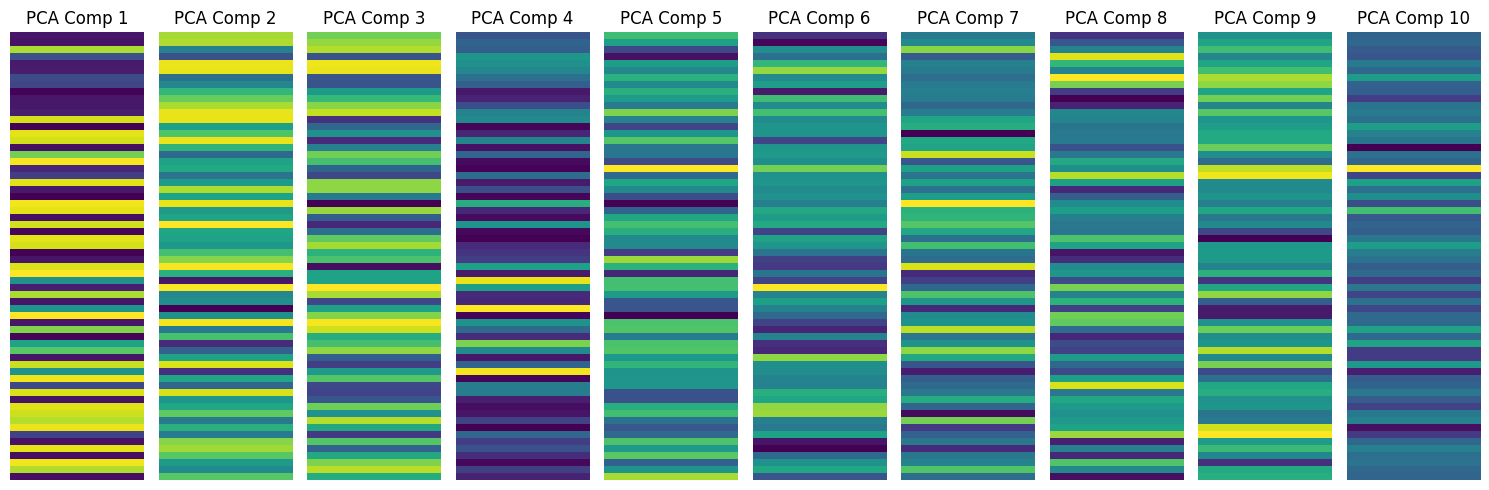

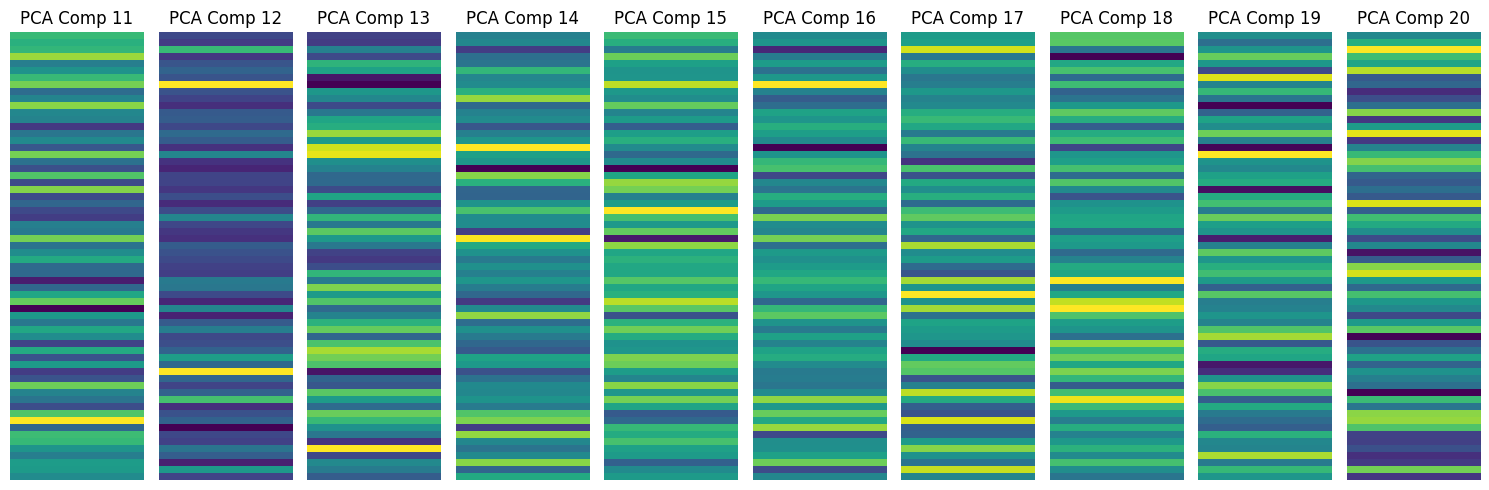

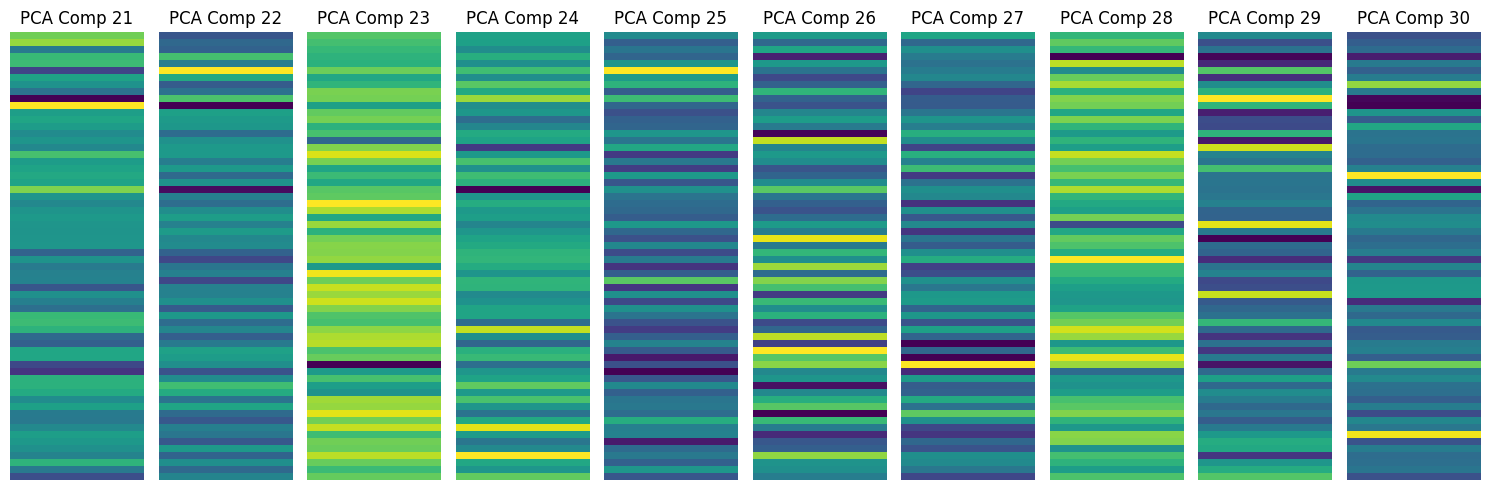

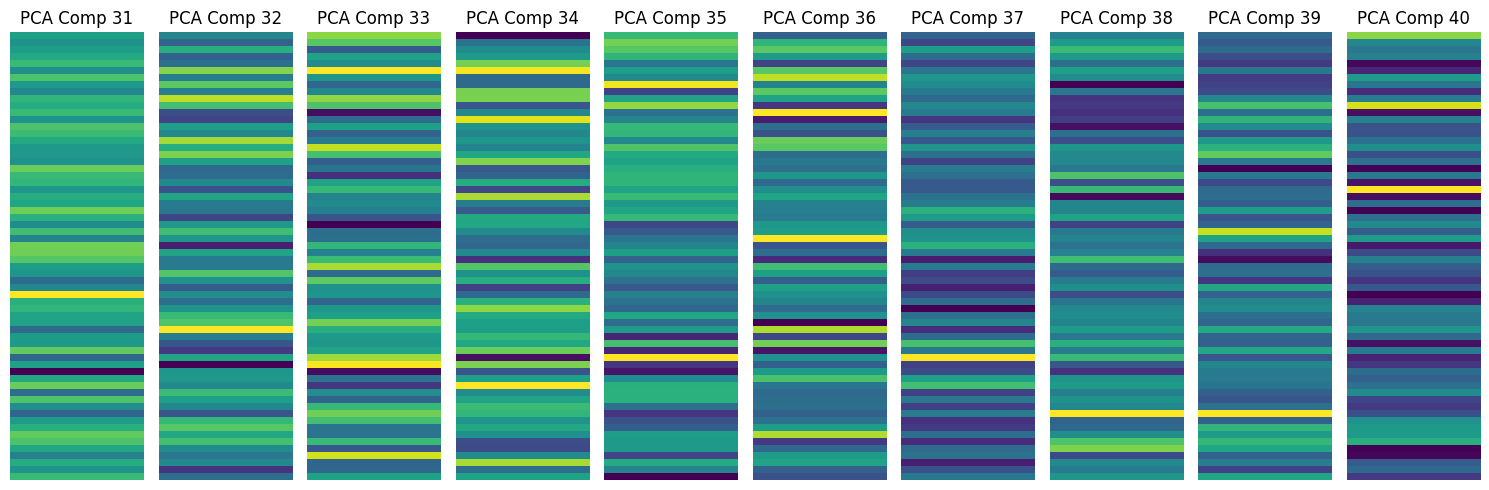

Epoch 6/40: Training Loss: 0.5780, Accuracy: 80.41%
Epoch 7/40: Training Loss: 0.5036, Accuracy: 81.18%
Epoch 8/40: Training Loss: 0.5197, Accuracy: 82.14%
Epoch 9/40: Training Loss: 0.5048, Accuracy: 82.26%
Epoch 10/40: Training Loss: 0.5252, Accuracy: 80.91%
Visualizing all PCA feature maps after epoch 10


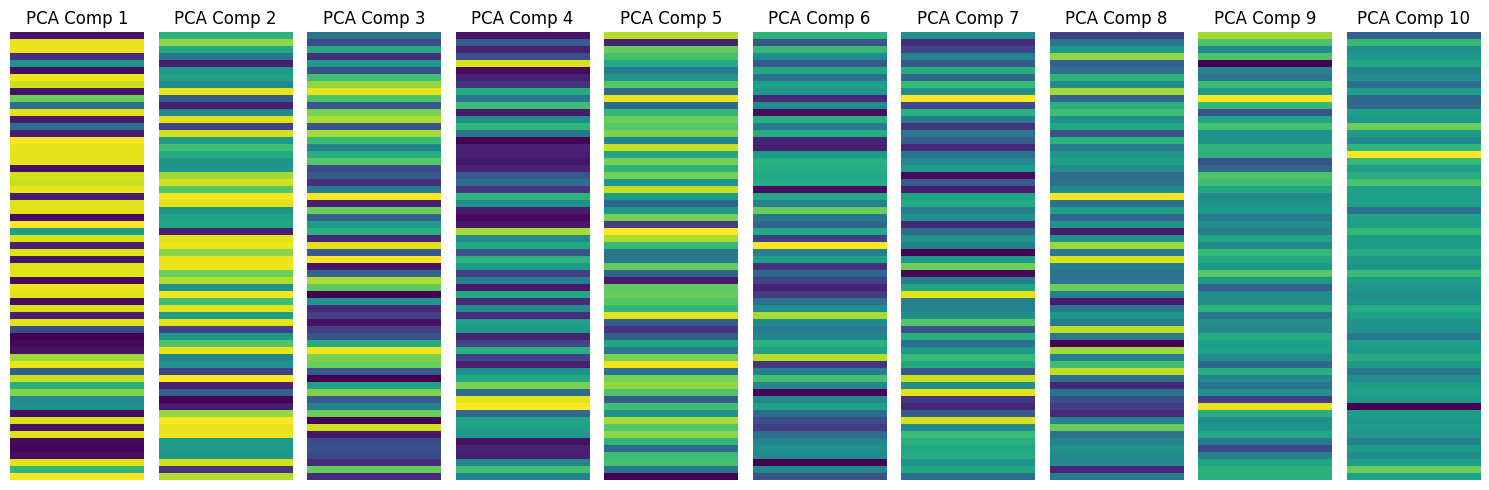

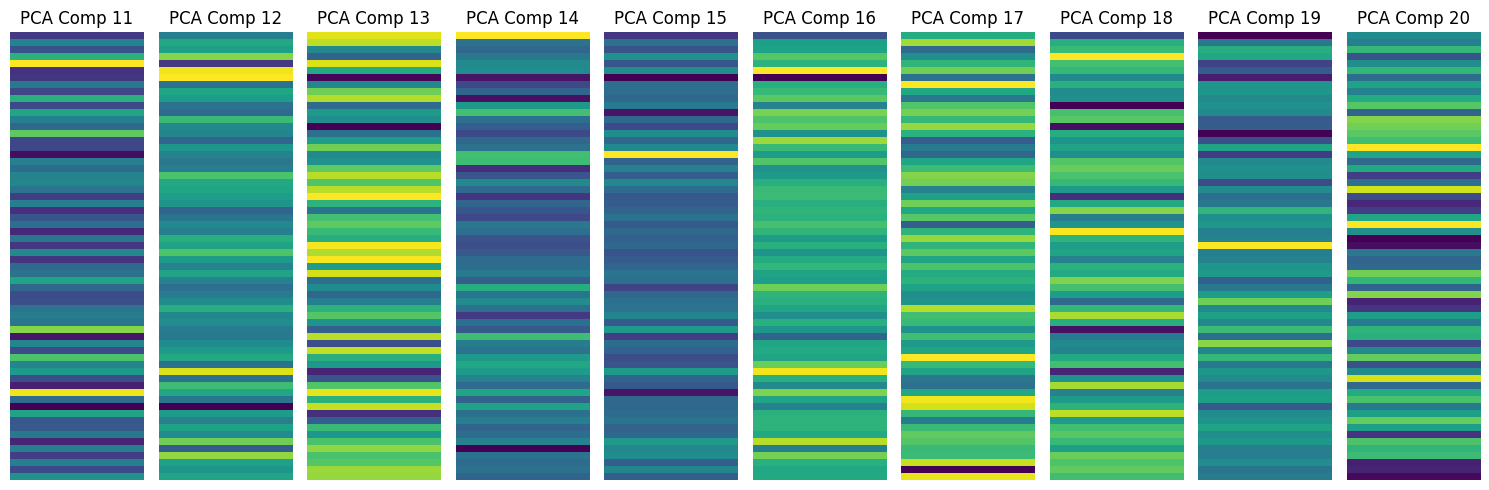

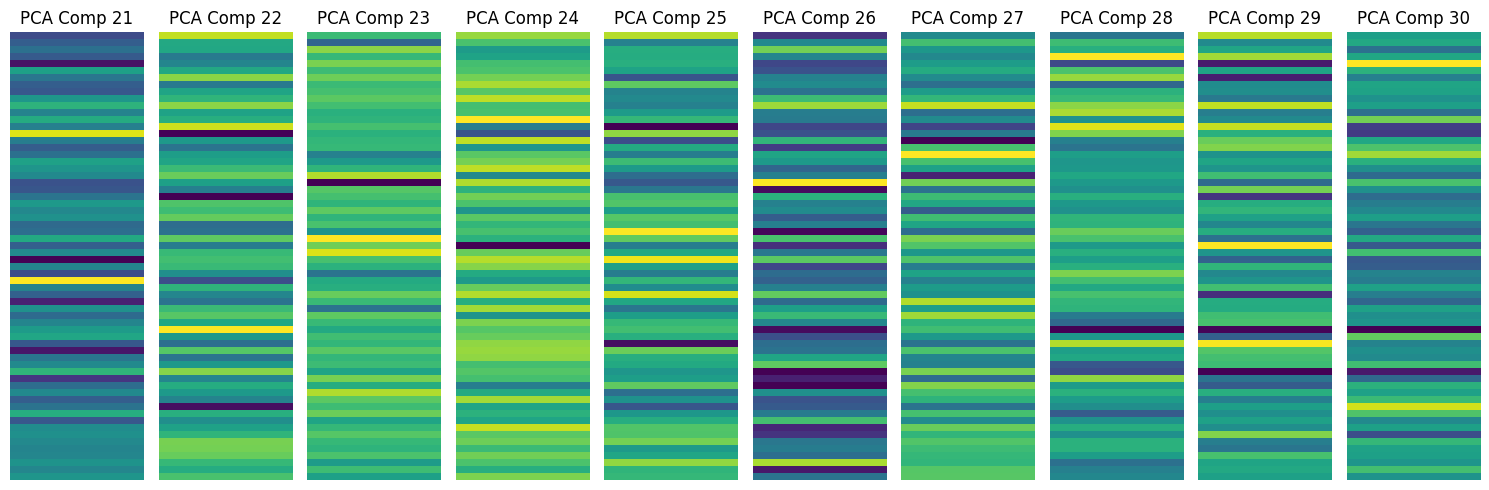

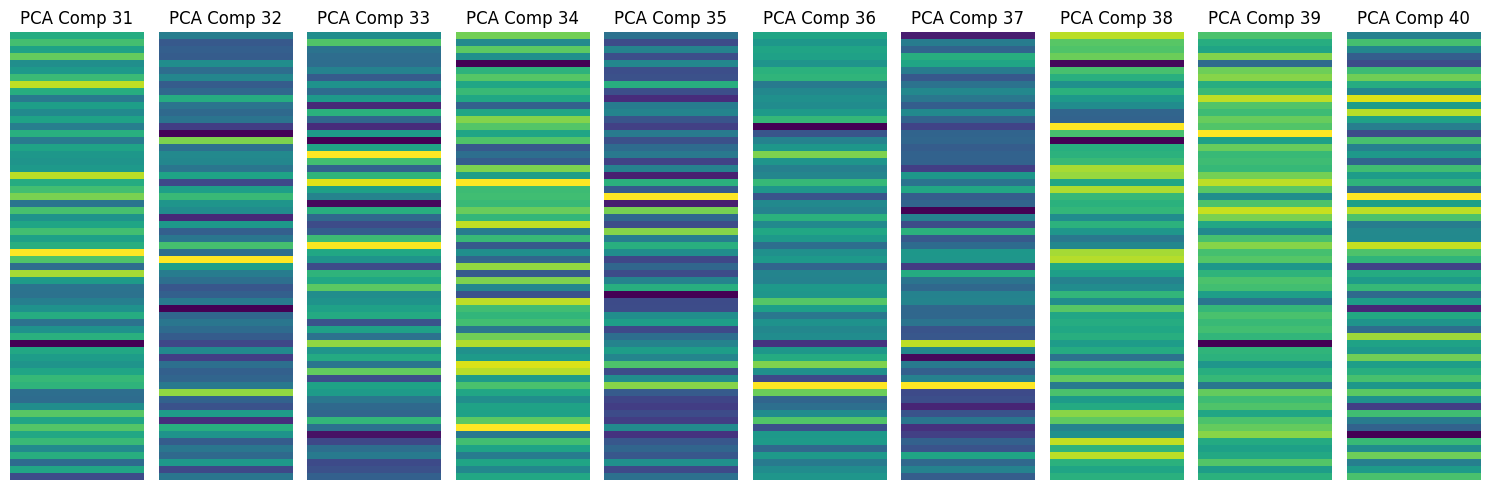

Epoch 11/40: Training Loss: 0.5051, Accuracy: 81.57%
Epoch 12/40: Training Loss: 0.5001, Accuracy: 81.18%
Epoch 13/40: Training Loss: 0.4965, Accuracy: 81.53%
Epoch 14/40: Training Loss: 0.4860, Accuracy: 82.18%
Epoch 15/40: Training Loss: 0.4905, Accuracy: 82.10%
Visualizing all PCA feature maps after epoch 15


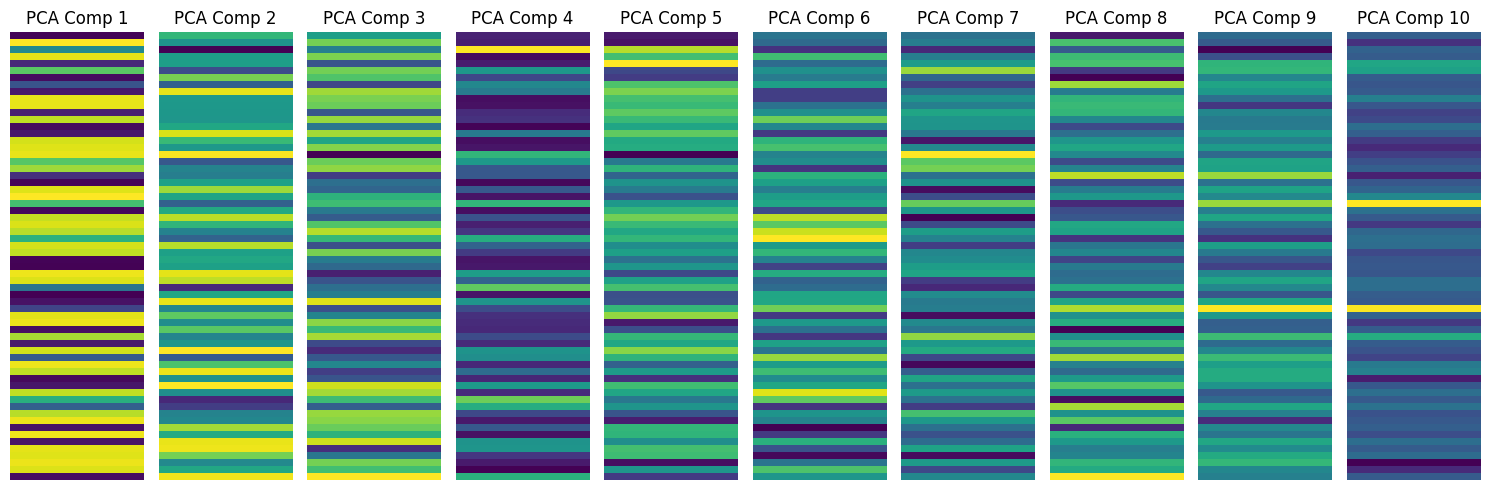

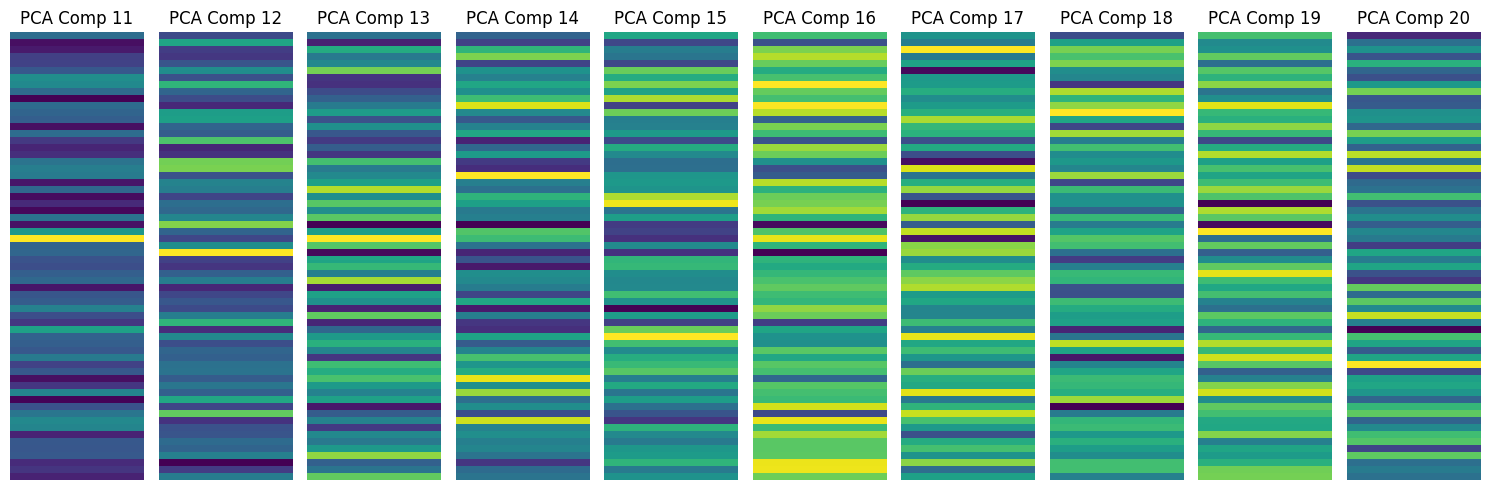

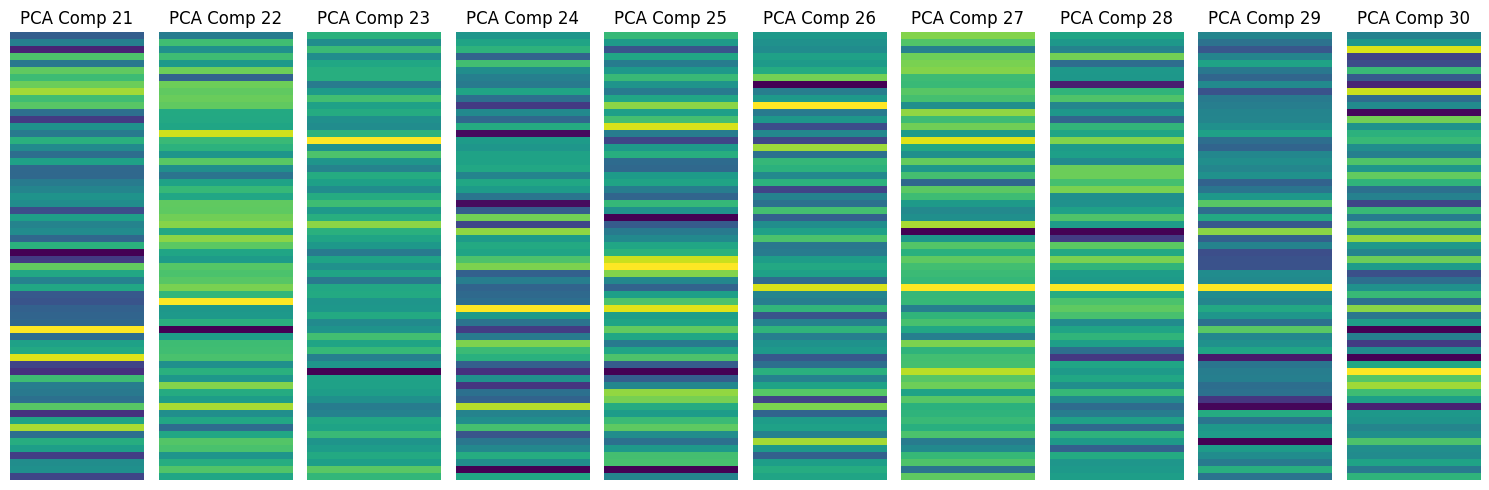

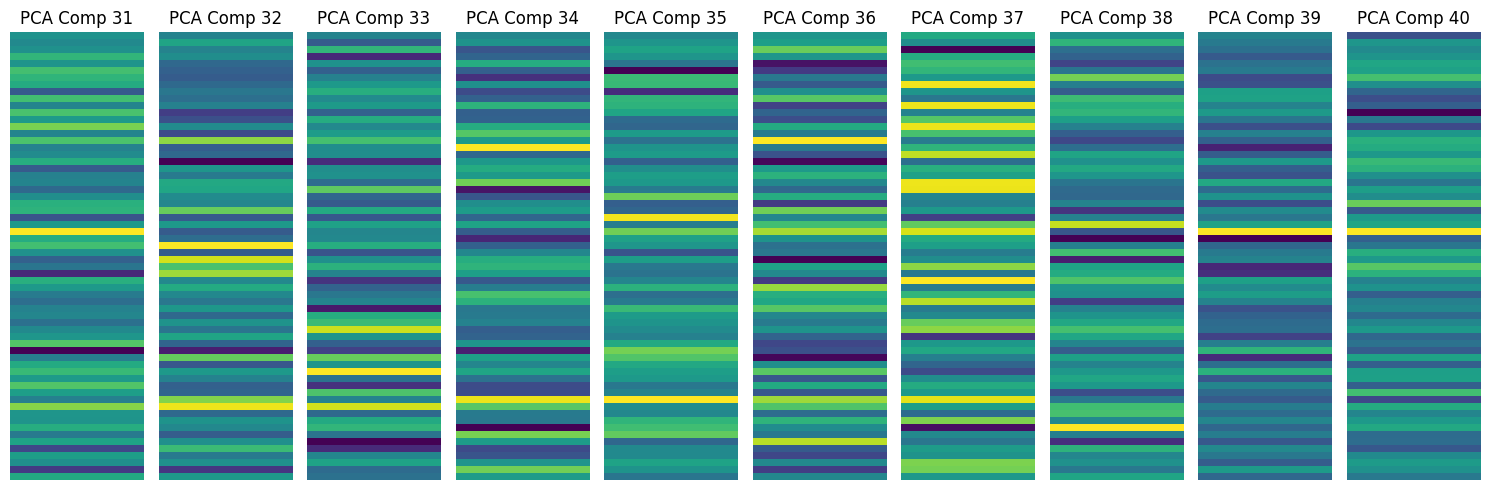

Epoch 16/40: Training Loss: 0.4646, Accuracy: 82.30%
Epoch 17/40: Training Loss: 0.4569, Accuracy: 82.45%
Epoch 18/40: Training Loss: 0.4768, Accuracy: 81.30%
Epoch 19/40: Training Loss: 0.4709, Accuracy: 82.64%
Epoch 20/40: Training Loss: 0.4793, Accuracy: 82.60%
Visualizing all PCA feature maps after epoch 20


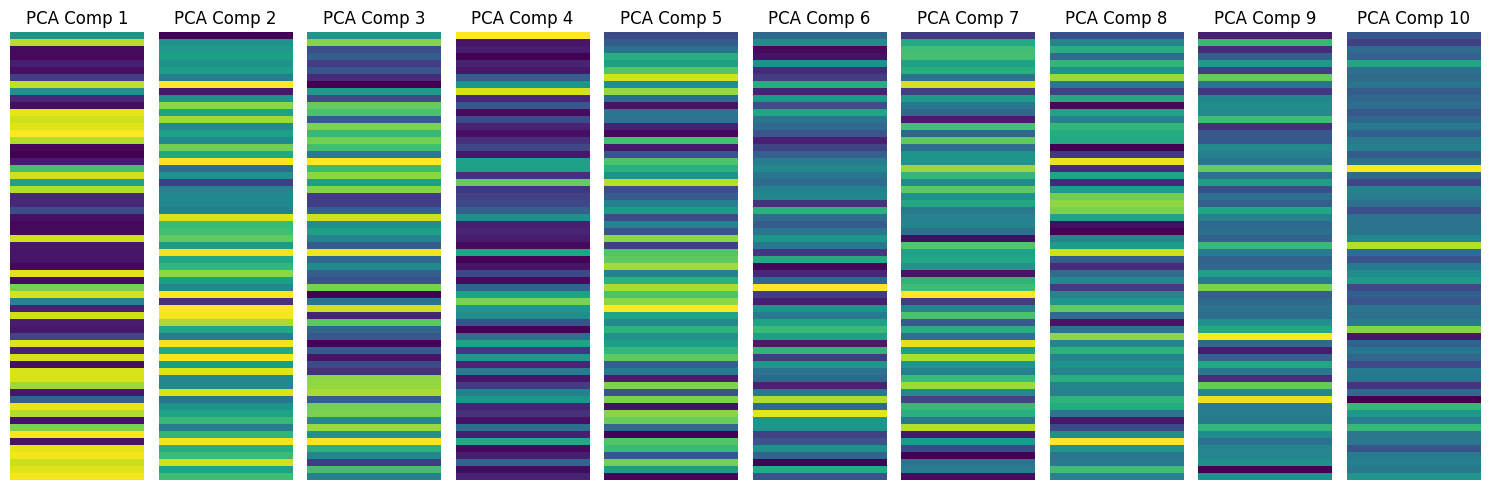

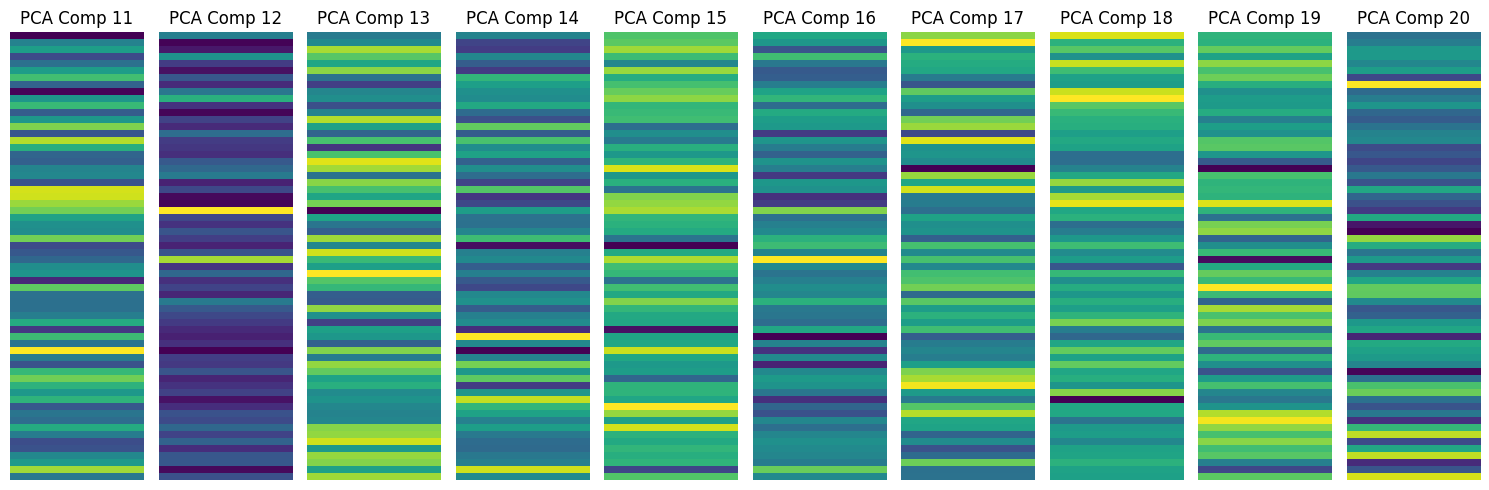

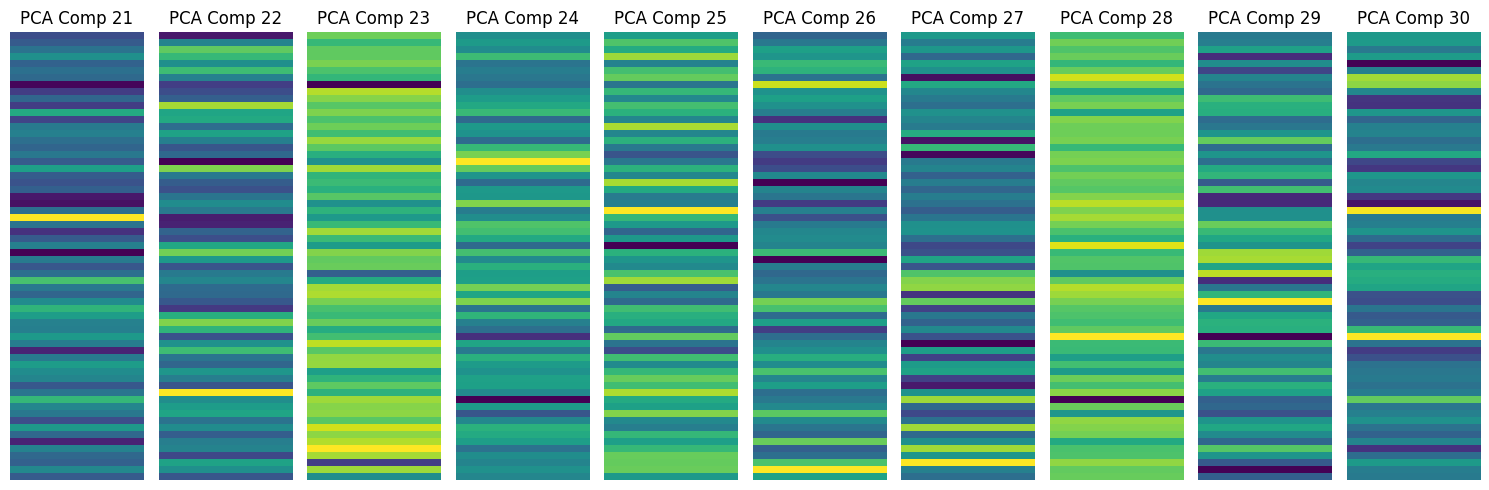

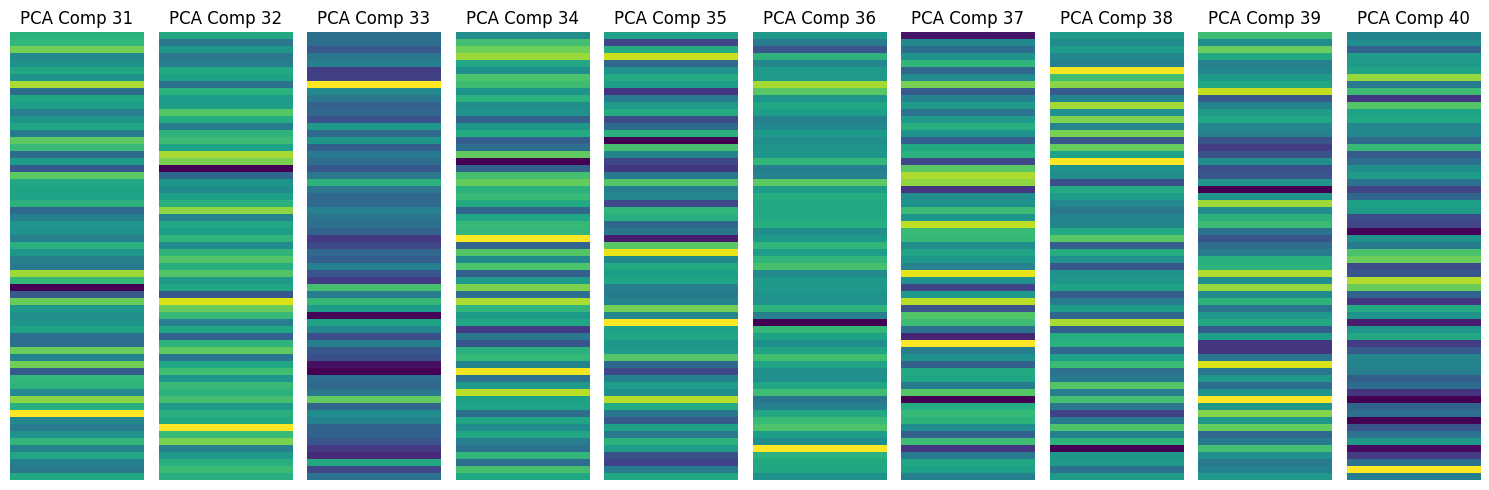

Epoch 21/40: Training Loss: 0.4869, Accuracy: 81.76%
Epoch 22/40: Training Loss: 0.4852, Accuracy: 81.57%
Epoch 23/40: Training Loss: 0.4874, Accuracy: 81.45%
Epoch 24/40: Training Loss: 0.4525, Accuracy: 82.72%
Epoch 25/40: Training Loss: 0.4544, Accuracy: 82.14%
Visualizing all PCA feature maps after epoch 25


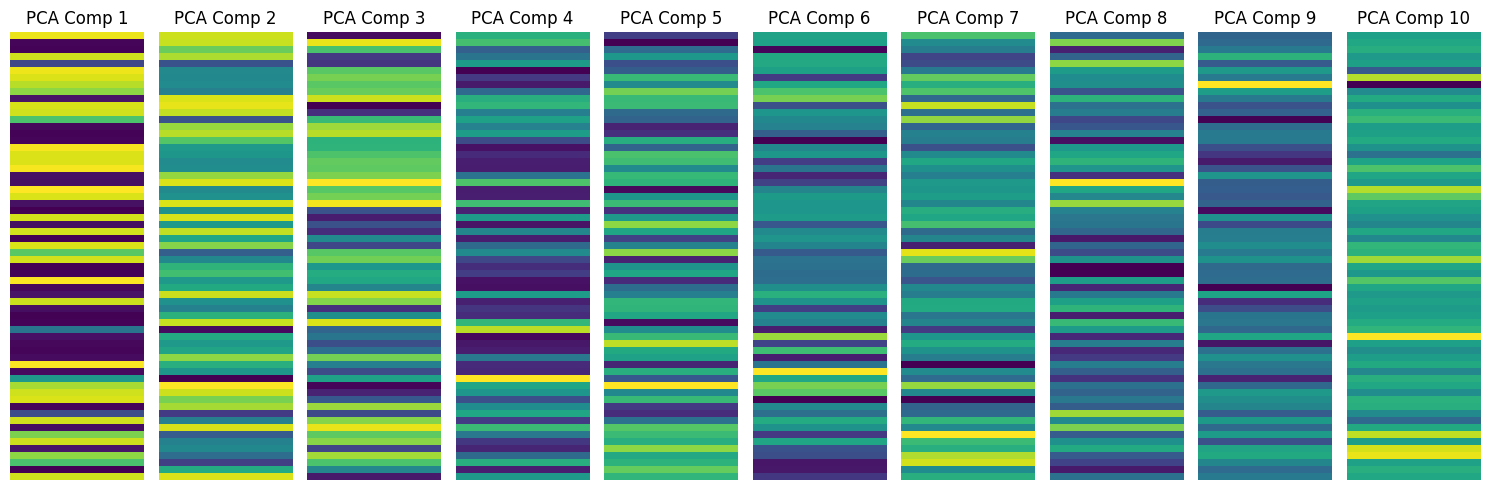

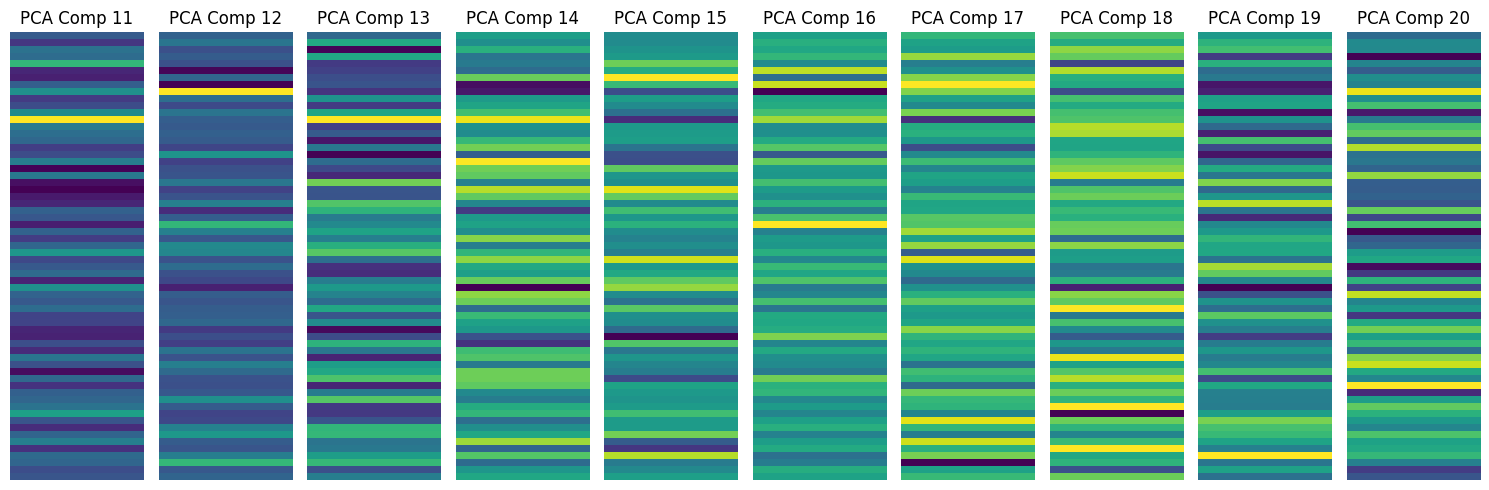

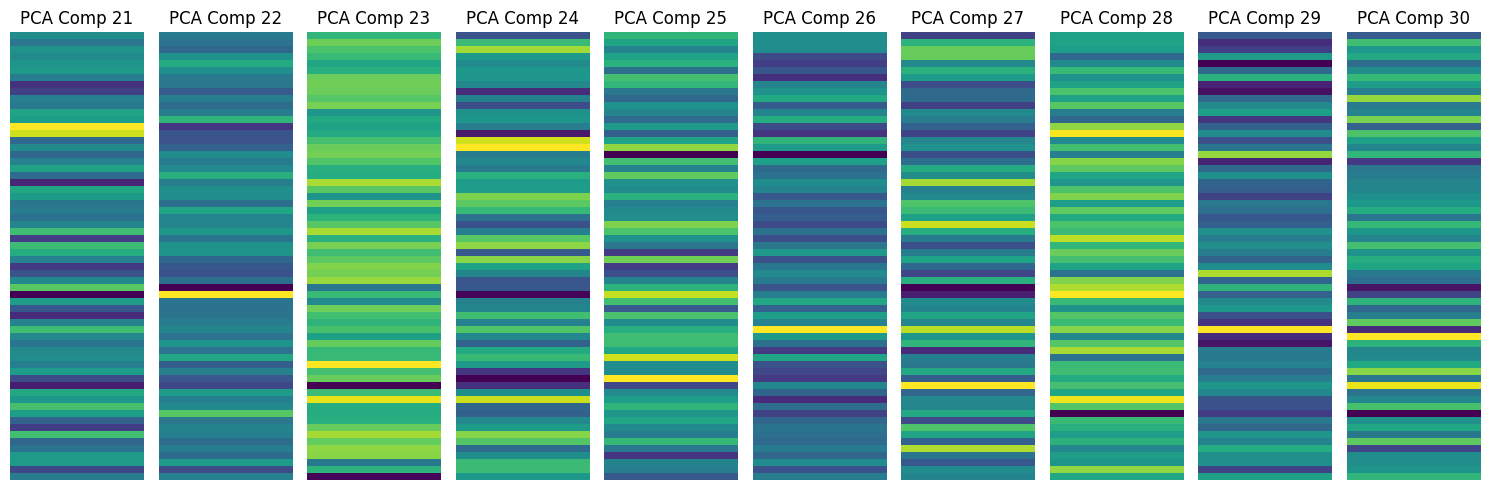

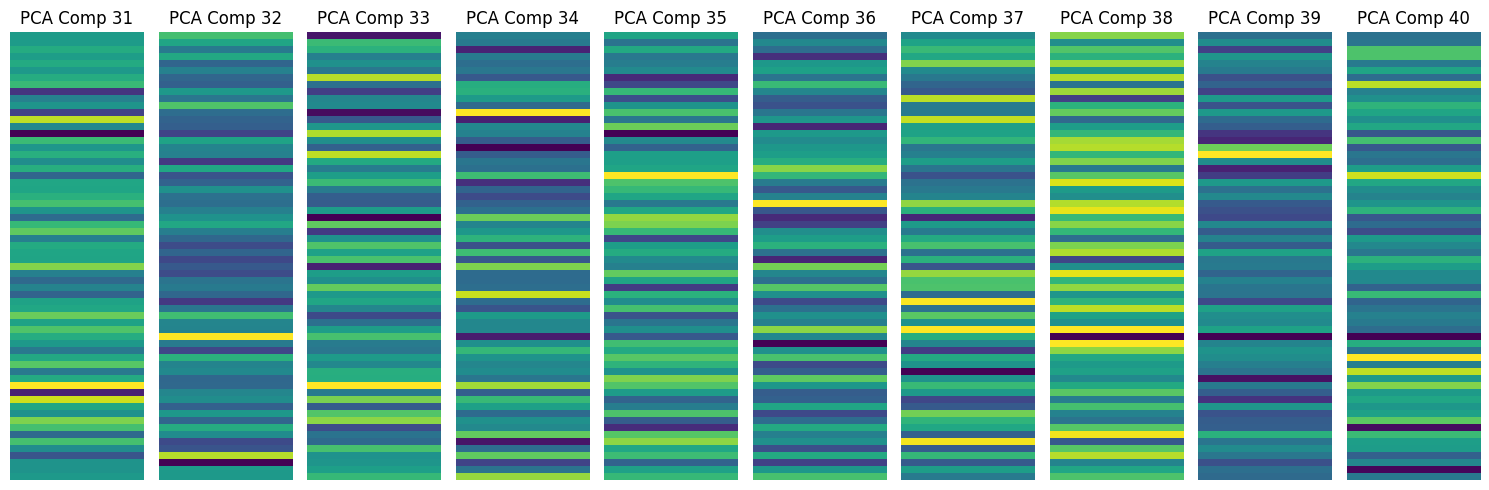

Epoch 26/40: Training Loss: 0.4667, Accuracy: 82.57%
Epoch 27/40: Training Loss: 0.4422, Accuracy: 82.37%
Epoch 28/40: Training Loss: 0.4628, Accuracy: 82.37%
Epoch 29/40: Training Loss: 0.4669, Accuracy: 82.30%
Epoch 30/40: Training Loss: 0.4668, Accuracy: 81.99%
Visualizing all PCA feature maps after epoch 30


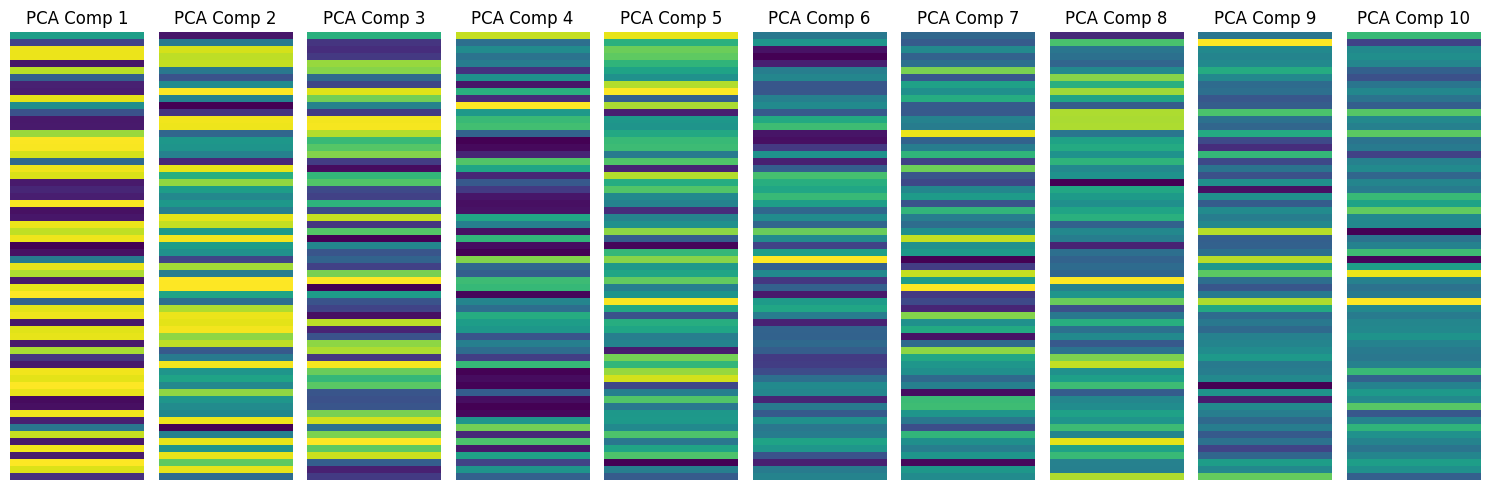

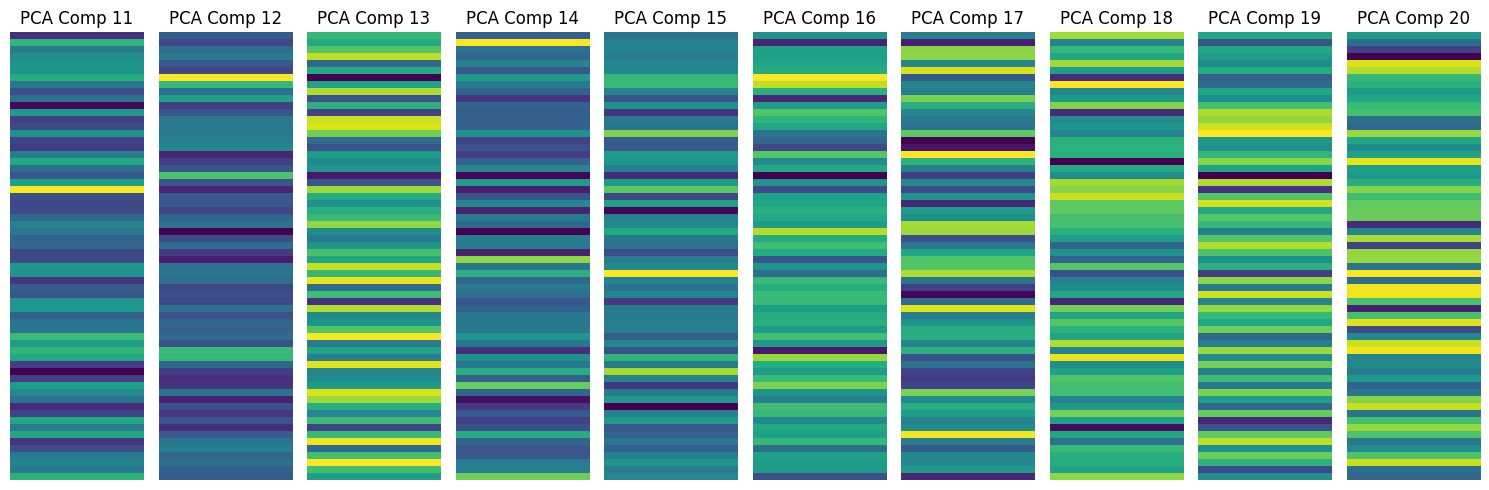

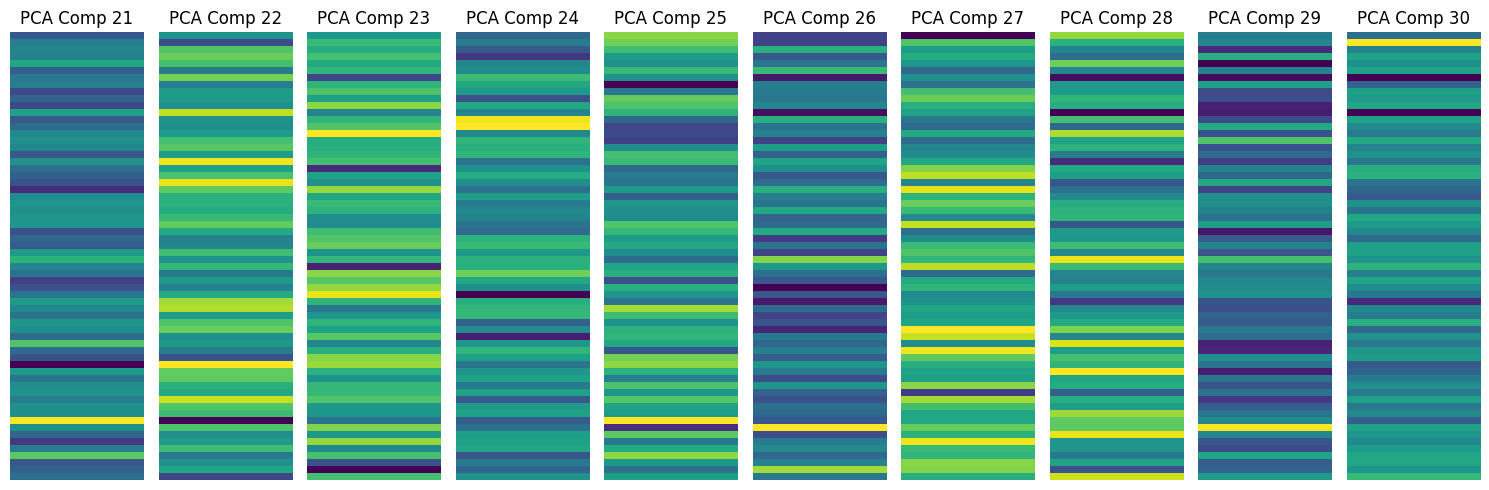

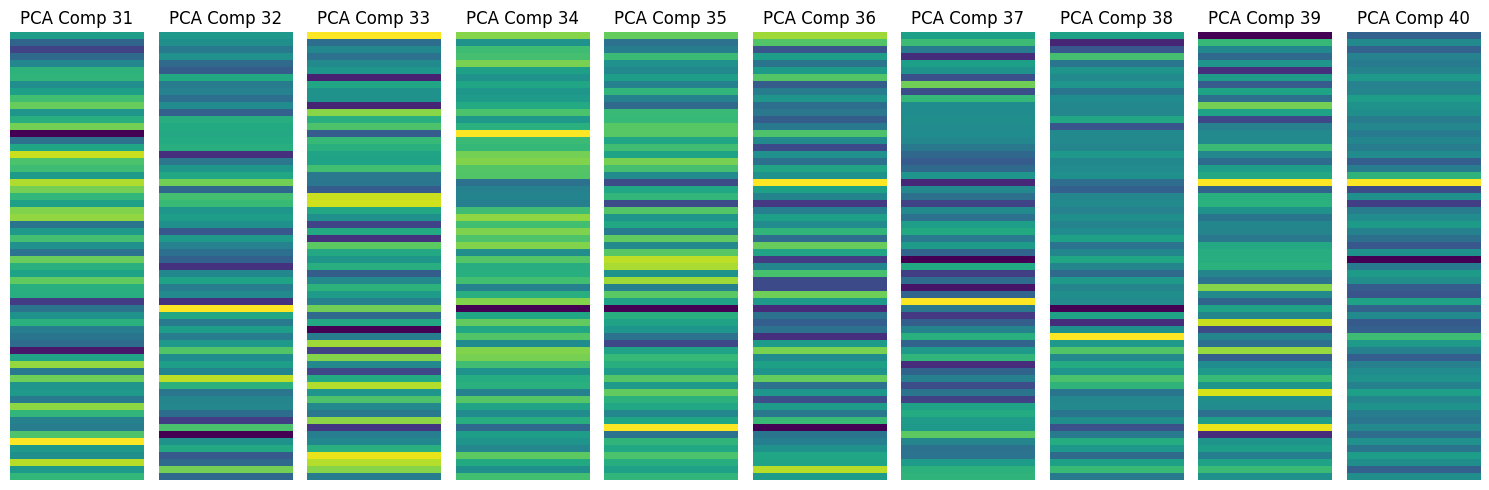

Epoch 31/40: Training Loss: 0.4582, Accuracy: 82.60%
Epoch 32/40: Training Loss: 0.4622, Accuracy: 82.91%
Epoch 33/40: Training Loss: 0.4278, Accuracy: 83.18%
Epoch 34/40: Training Loss: 0.4314, Accuracy: 82.49%
Epoch 35/40: Training Loss: 0.4328, Accuracy: 83.60%
Visualizing all PCA feature maps after epoch 35


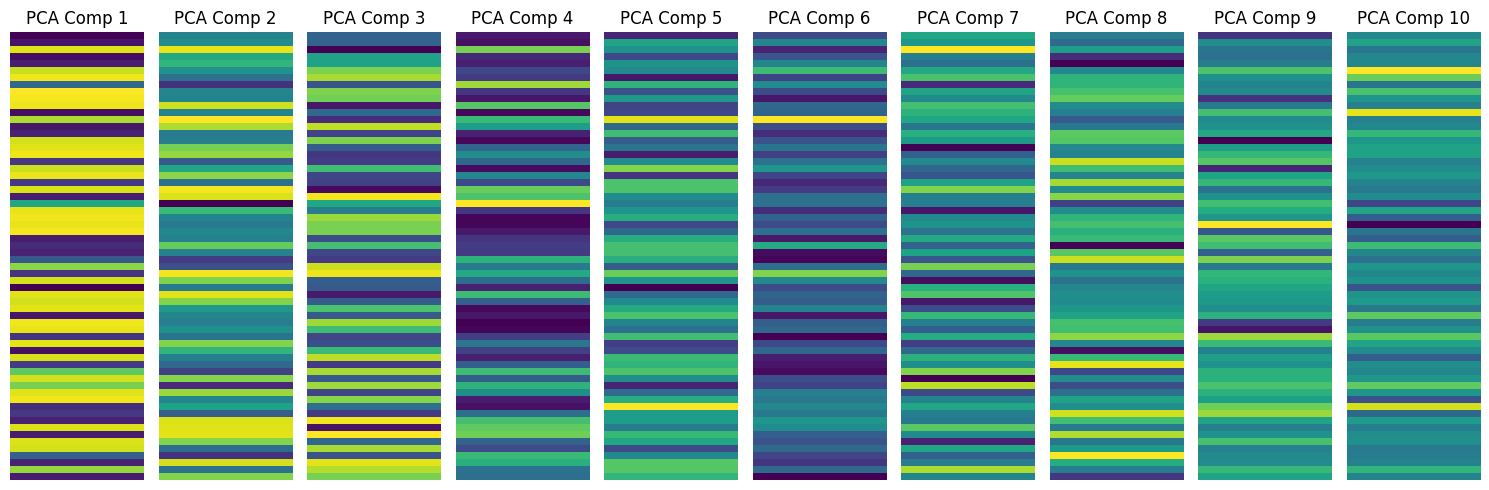

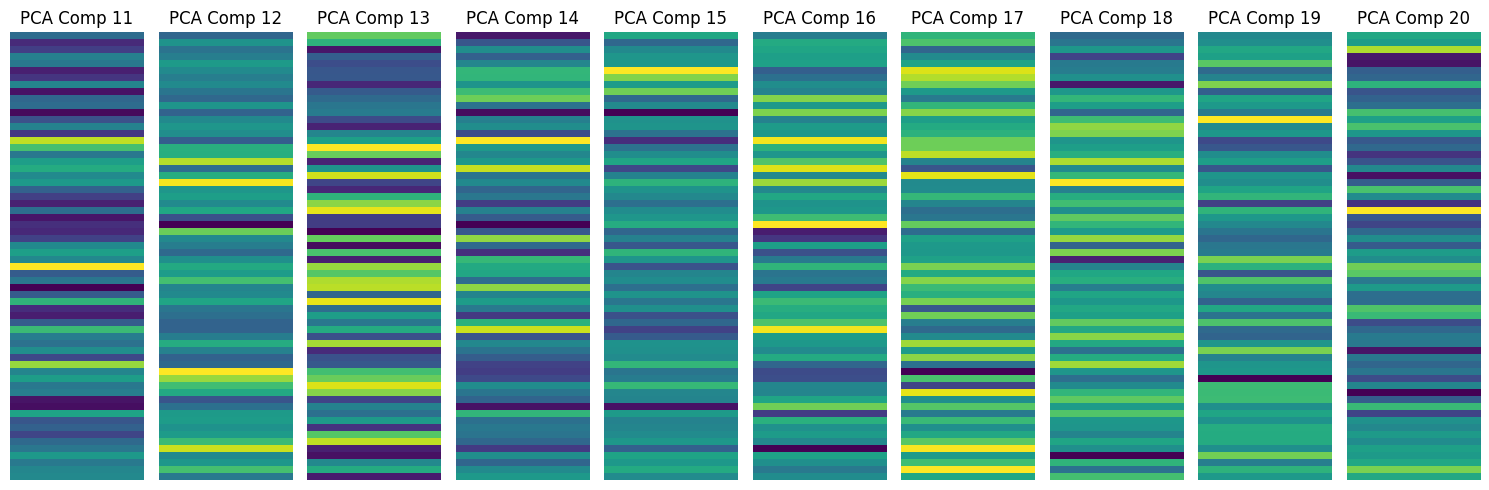

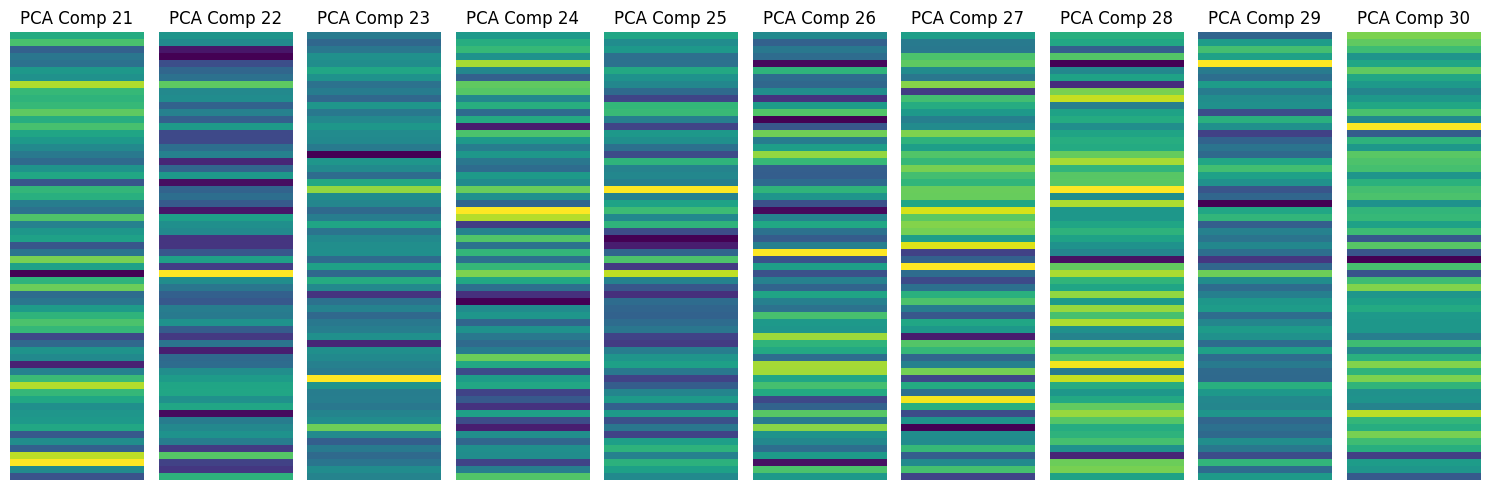

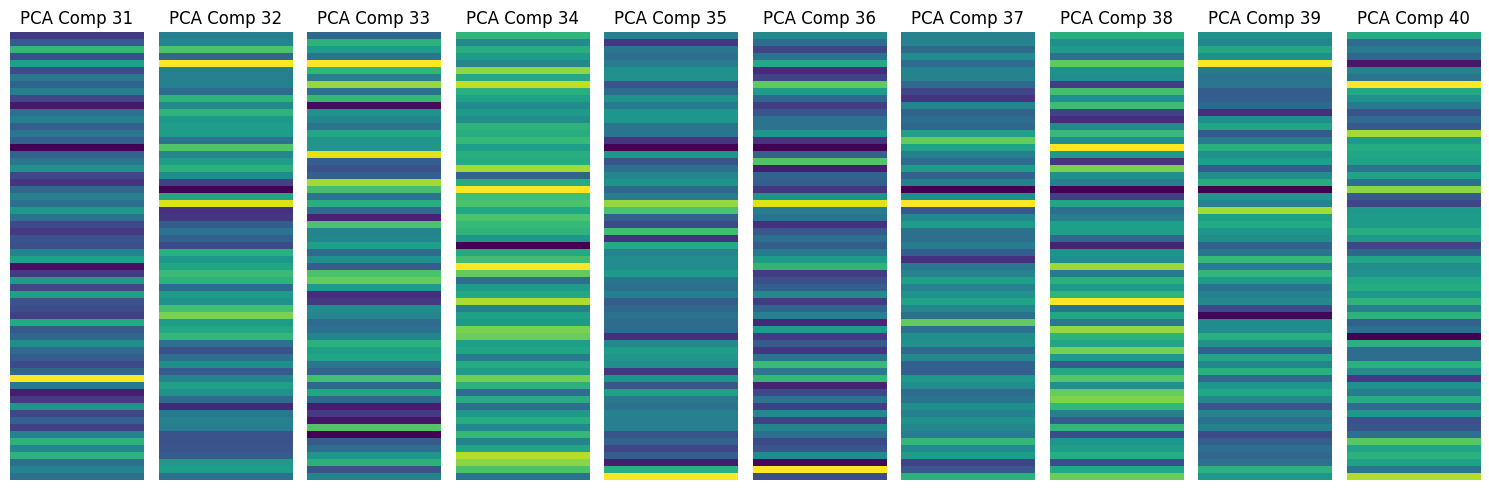

Epoch 36/40: Training Loss: 0.4358, Accuracy: 83.14%
Epoch 37/40: Training Loss: 0.4436, Accuracy: 82.76%
Epoch 38/40: Training Loss: 0.4330, Accuracy: 83.10%
Epoch 39/40: Training Loss: 0.4167, Accuracy: 83.64%
Epoch 40/40: Training Loss: 0.4428, Accuracy: 82.80%
Visualizing all PCA feature maps after epoch 40


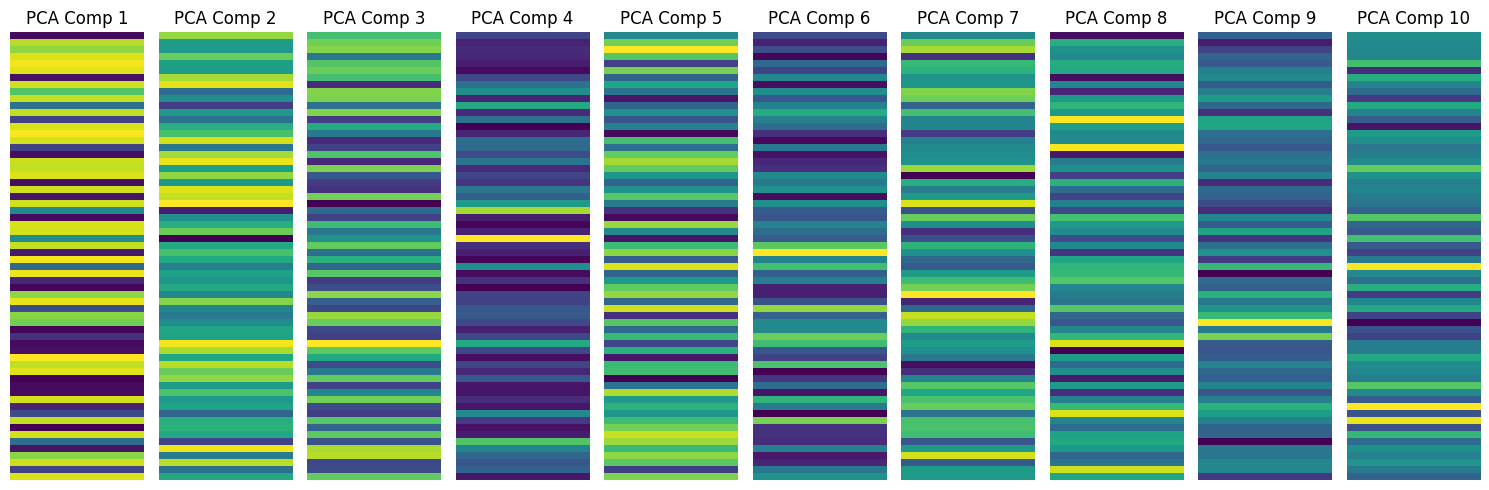

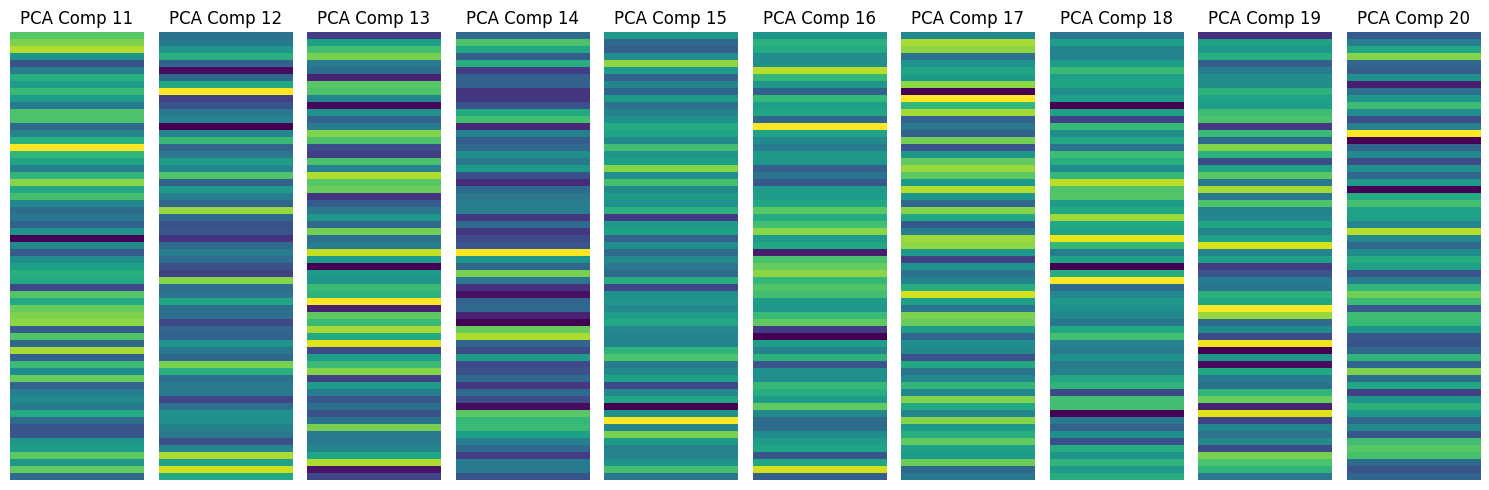

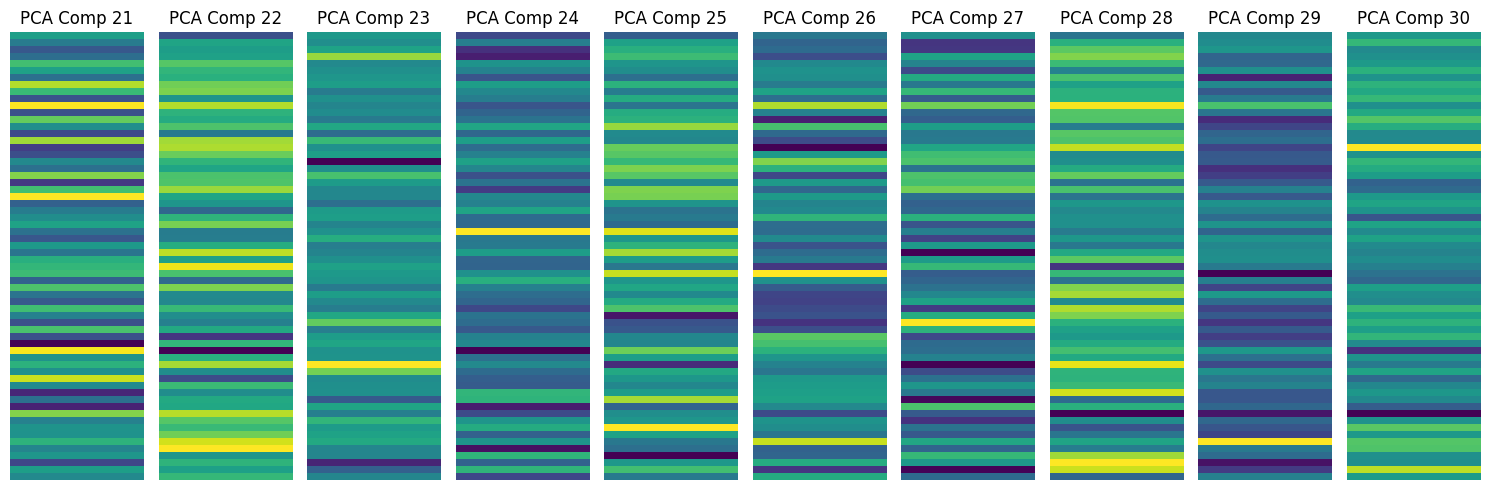

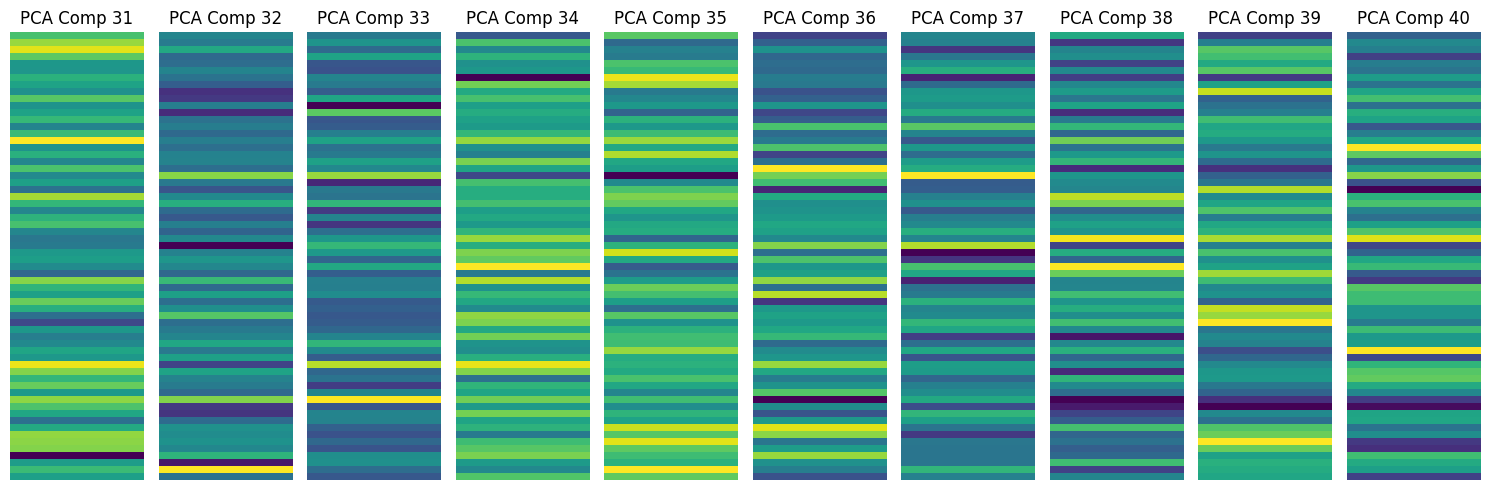

In [30]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct_predictions / total_samples
        print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
          # Example during training
         # Visualize PCA-transformed feature maps after every 5 epochs
        if (epoch + 1) % 5 == 0:
            sample_batch, _ = next(iter(train_loader))  # Get a sample batch
            print(f"Visualizing all PCA feature maps after epoch {epoch+1}")
            plot_all_pca_feature_maps(model, sample_batch, group_size=10, device=device)



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40)
